# Exploration and Feature Engineering

## Overview
For this project, we're going to take a time series database and try and transform the data into a more straightforward supervised learning challenge. This will be done by adding lag variables to the data. When done correctly lag variables give all the necessary temporal information at any individual point so that we can treat each example in the data as independent and use a regualr regression model.

The only information we have in the dataset is historic sales by item and store. In this notebook we examine what seasonal trends exist to figure out what information needs to be encoded in our lag variables

---
### Load libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
gc.collect()

7

In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
len_train = len(train)
df = pd.concat([train, test], sort=False)

let's take a look at the columns

In [4]:
df.columns

Index(['date', 'store', 'item', 'sales', 'id'], dtype='object')

---
### Extract more information from datetime
This will be useful for both visualisation as well as for modelling.

In [5]:
df.date = pd.to_datetime(df.date)

df['day_of_month'] = df.date.dt.day
df['day_of_week'] = df.date.dt.dayofweek
df['day_of_year'] = df.date.dt.dayofyear
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['week_of_year'] = df.date.dt.weekofyear

---
### Visualise Trends
We will now visualise various intervals, year against year to try and see trends in the data



======= Interval: day_of_month =======


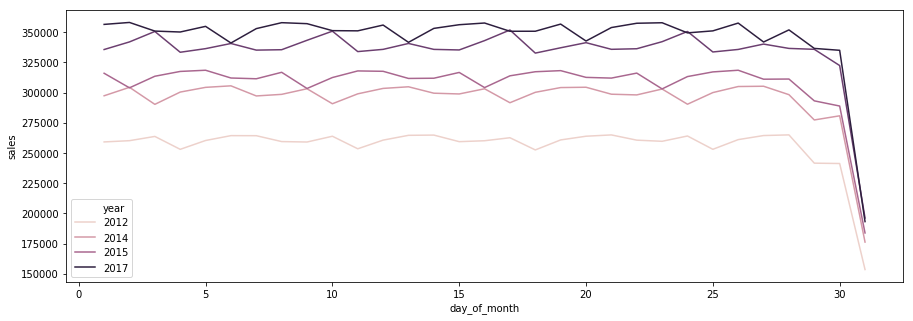



======= Interval: day_of_year =======


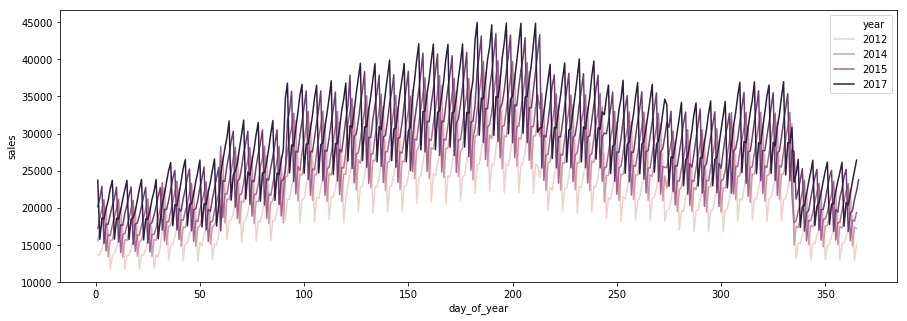



======= Interval: month =======


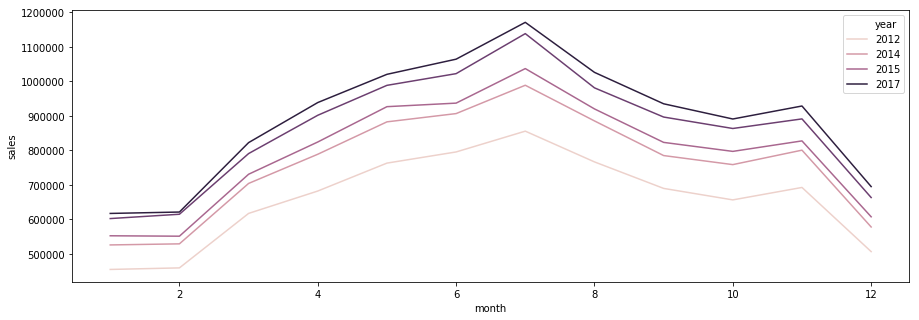



======= Interval: week_of_year =======


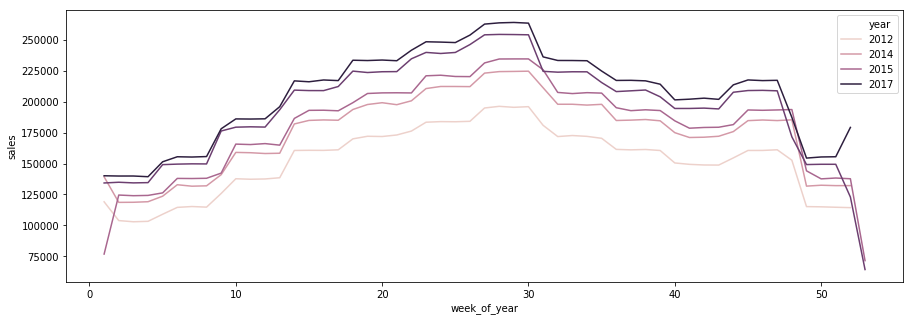



======= Interval: day_of_week =======


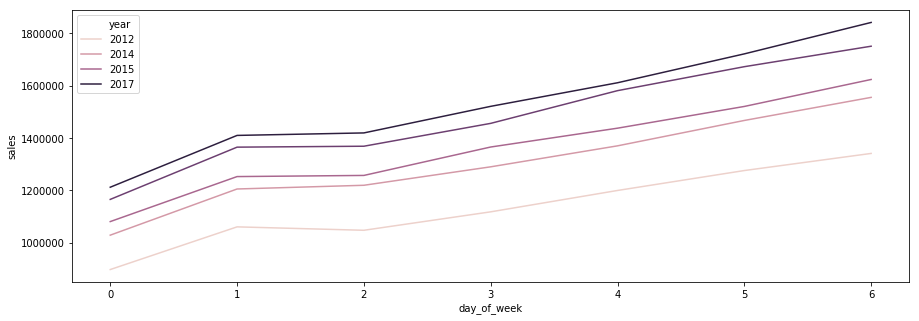

In [6]:
def compare_year_on_trend(df, interval):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(x=interval, y='sales', hue='year',
                 data=df.groupby(['year', interval]).sales.sum().reset_index(),
                 ax=ax)
    plt.show()
    
train = df[:len_train]   
intervals = ['day_of_month', 'day_of_year', 'month', 'week_of_year', 'day_of_week']
for interval in intervals:
    print('\n\n======= Interval: {} ======='.format(interval))
    compare_year_on_trend(train, interval)

It is pretty clear there is weekly and annual trend, but no monthly trend. The weekly and annual trend also both seem to be one rise/fall and not multiple peaks and troughs. There is also a clear year on year growth every year.

---
## Feature engineering
The targets we have to predict are three months beyond any current data. To encapsulate the above trends we should be including recent sales data, as well as sales from the same time one year ago, and two years ago (more years would probably be ideal but we only have 5 years of historic data and we don't want too many missing values).

In [7]:
# we need to sort the data and reset the index so that shifting the sales forward by 500 (50 items x 10 stores)
# we get the sales for item+store combination from the previous day
df.sort_values(['date', 'store', 'item'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.head()

,date,store,item,sales,id,day_of_month,day_of_week,day_of_year,month,year,week_of_year
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2013,1
1,2013-01-01,1,2,33.0,NaN,1,1,1,1,2013,1
2,2013-01-01,1,3,15.0,NaN,1,1,1,1,2013,1
3,2013-01-01,1,4,10.0,NaN,1,1,1,1,2013,1
4,2013-01-01,1,5,11.0,NaN,1,1,1,1,2013,1


### creating lag variables
The function below will give the mean sales for every item+store combination over the last X days starting from the period Y.
For example when shift_period = 91, and window = 7, that gives us the mean sales for the last seven days from that day 91 days ago. To make that even more clear for January 1st we would have the mean sales for September 26th-October 2nd (October 2nd being 91 days before January 1st, and then getting the mean of the previous seven days sales).

The `shift_periods` variables represents how far back we will look (in days). The `windows` variable represents for what periods will we calculate the mean sales from.

In [9]:
shift_periods = [91, 98, 105, 112, 182, 365, 365+7, 365+14, 365+21, 730, 730+7, 730+14, 730+21]
windows = [7, 14, 21, 28, 60, 90]
for sp in shift_periods:
    sp_col = 'shift_sales_{}'.format(sp)
    df[sp_col] = df.sales.shift(500*sp)
    gpby = df.groupby(['item', 'store'])[sp_col]
    for window in windows:
        df['sales_lag_{}_wdw_{}'.format(sp, window)] = gpby.rolling(window).mean().sort_index(level=2).values
    df.drop(sp_col, axis=1, inplace=True)

In [10]:
# don't need this anymore
df.drop('date', axis=1, inplace=True)

---
split and save data

In [11]:
final_train = df[:len_train]
final_test = df[len_train:]

print('final train shape: ', final_train.shape)
print('final test shape:  ', final_test.shape)

final train shape:  (913000, 88)
final test shape:   (45000, 88)


In [13]:
final_train.to_csv('data/final_train.csv', index=False)
final_test.to_csv('data/final_test.csv', index=False)